In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import MINST data, split it into X ad Y, isolate X1, X2 and X3 from X <br>
where X1 = subdata of X containing 0, X2 = 6, X3 = 9

In [142]:
#function to randomly divide data into test and train sets
def trainTestSets(X, Y, perc,N):

    #divide in Xtrain and Xtest
    trainSize=int(perc*N/100)
    Xtrain=X[:,:trainSize]
    Ytrain=Y[:trainSize]
    Xtest=X[:,trainSize:N]
    Ytest=Y[trainSize:N]
    return Xtrain, Ytrain, Xtest, Ytest

#load data into memory
data=pd.read_csv("data.csv")
#print(data.head())
#convert data into matrix
data=np.array(data)
np.random.shuffle(data)
#split data into X and Y
X=data[:,1:].T 
Y=data[:,0]


#isolate X1, X2, X3
i1= (Y==0)
print(i1)
i2= (Y==6)
i3= (Y==9)
X=X[:, i1+i2+i3]
Y=Y[i1+i2+i3]
d,N=X.shape
print(N)
#divide in train and test sets
Xtrain, Ytrain, Xtest, Ytest = trainTestSets(X,Y,60,N)
print(Xtrain.shape)
i1= (Ytrain==0)
i2= (Ytrain==6)
i3= (Ytrain==9)
X1=Xtrain[:, i1]
X2=Xtrain[:, i2]
X3=Xtrain[:, i3]

Y1=Ytrain[i1]
Y2=Ytrain[i2]
Y3=Ytrain[i3]


[False  True False ... False False  True]
12457
(784, 7474)


In [143]:
Xtrain=np.concatenate((X1,X2,X3), axis=1)
Ytrain=np.concatenate((Y1,Y2,Y3))

the difference between PCA and LDA is the <b>class centroid</b>
which is the centroid calculated considering just the class k

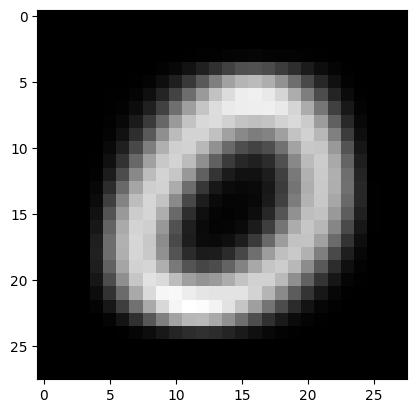

In [144]:
#calculate global and class centroids

#global centroid
C=np.mean(Xtrain, axis=1)

#class centroids
C1=np.mean(X1, axis=1)
C2=np.mean(X2, axis=1)
C3=np.mean(X3, axis=1)

plt.imshow(np.reshape(C1,(28,28)), cmap="gray") #C1 is the IMAGE (28*28), mean of all zeros

In [145]:
d=784
X1c=X1-C1.reshape((d,1))
X2c=X2-C2.reshape((d,1))
X3c=X3-C3.reshape((d,1))

Xw=np.concatenate((X1c, X2c, X3c), axis=1)
Sw= Xw@Xw.T #represents the spread of the data within each cluster
#it's SYMMETRICAL by construction
#it's not positive definite by contruction


Xbar1= np.repeat(C1.reshape(d,1), X1.shape[1], axis=1)
Xbar2= np.repeat(C2.reshape(d,1), X2.shape[1], axis=1)
Xbar3= np.repeat(C3.reshape(d,1), X3.shape[1], axis=1)

Xbar=np.concatenate((Xbar1, Xbar2, Xbar3), axis=1)
Xbarc=Xbar-C.reshape((d,1)) #we can't subtract matrix and vector, but we can subtract matrix and column vector (that's wy we reshape C)

Sb=Xbarc @ Xbarc.T #represent the spread between different clusters
print(Sb.shape)

(784, 784)


we need to <b>minimize Sw</b> and <b>maximize Sb</b> <br>
we use cholesky decomposition (LU for positive definite matrixes)<br>
Sw is symmetric, but we have to make it positive definite (<b>"regularize"</b>), by adding epsilon\*I (epsilon=1\*10^-6, I is the identical matrix)<br>
function <b><i>np.linalg.cholesky(Sw)</i></b>

In [146]:
try:
    L=np.linalg.cholesky(Sw)
except:
    epsilon=1e-6
    Sw=Sw+(epsilon*np.eye(Sw.shape[0]))
    L=np.linalg.cholesky(Sw)
print(L.shape)


(784, 784)


 given a number k (representing the dimension on which we want to project), compute the matrix W, whose column are the first k <b>LARGEST</b> eigenvectors of L@Sb@LT.<br>
 HINT: use <i>scipy.sparse.linalg.eigs()</i> and truncate first k columns (k=2, passed as parameter)

In [147]:
import scipy.sparse.linalg as sp

tmp=np.linalg.inv(L)@Sb@L
v,W=sp.eigs(tmp, k=2)
W=np.real(W) #W should be made of real values, but because of machine 
print(W.shape)

(784, 2)


Now we want to calculate the projection matrix Q=L^-1@W

In [148]:
Q=np.linalg.inv(L.T)@W
print(Q.T.shape)

(2, 784)


Now we project X in W and plot with plt.scatter<br>
We also project the centroids, so we can plot them with the points in 2D

(2, 1)


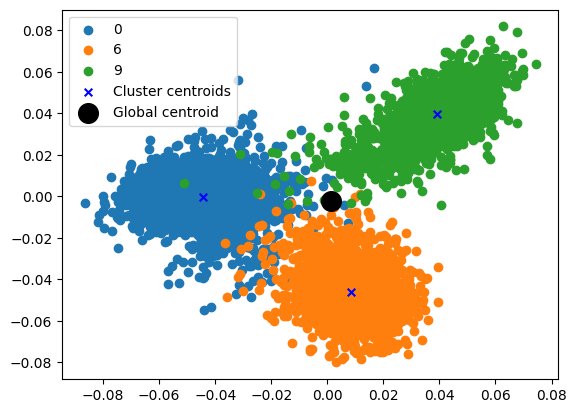

In [153]:
Z=Q.T@Xtrain
'''C1z=Q.T@C1.reshape(d,1)
C2z=Q.T@C2.reshape(d,1)
C3z=Q.T@C3.reshape(d,1)
Cz=Q.T@C.reshape(d,1)'''

#plot
Z1=Z[:,Ytrain==0]
Z2=Z[:,Ytrain==6]
Z3=Z[:,Ytrain==9]
plt.scatter(Z1[0,:], Z1[1,:], label="0") #c means color -> we color the data based on the label
plt.scatter(Z2[0,:], Z2[1,:], label="6") #c means color -> we color the data based on the label
plt.scatter(Z3[0,:], Z3[1,:], label="9") #c means color -> we color the data based on the label

#calculate centroids
C1z=np.mean(Z1, axis=1).reshape(k,1)#0
C2z=np.mean(Z2, axis=1).reshape(k,1)#6
C3z=np.mean(Z3, axis=1).reshape(k,1)#9
Cz=np.mean(Z, axis=1).reshape(k,1)
print(C1z.shape)

plt.scatter(C1z[0], C1z[1], c="blue",s=30, marker="x", label="Cluster centroids")
plt.scatter(C2z[0], C2z[1], c="blue",s=30, marker="x")
plt.scatter(C3z[0], C3z[1], c="blue",s=30, marker="x")
plt.scatter(Cz[0], Cz[1], c="black",s=200, marker="o", label="Global centroid")
plt.legend()
plt.show()


NOTE: LDA is more accurate (in classification), and better shows the distinction between different classes, but is slower compared to PCA.<br> 
PCA is faster, but less accurate than LDA, and classes overlap on each other when plotted, making it diffucult to distinguish them.<br>


In [150]:
D1=0
for i in Z1[1]:
    D1+=np.linalg.norm(C1z-Z1)**2
D1=D1/Z1.shape[1]
print(f"average distance form C1: {D1}")

D2=0
for i in Z2[1]:
    D2+=np.linalg.norm(C2z-Z2)**2
D2=D2/Z2.shape[1]
print(f"average distance form C2: {D2}")

D3=0
for i in Z3[1]:
    D3+=np.linalg.norm(C3z-Z3)**2
D3=D3/Z3.shape[1]
print(f"average distance form C3: {D3}")

average distance form C1: 0.7014856583688838
average distance form C2: 0.5940515447261838
average distance form C3: 0.7044617161909469


We can calculate accuracy using the test sets (average of correct guesses)

(2,) (2, 1)
4983
3312
prediction accuracy = 0.6646598434677905


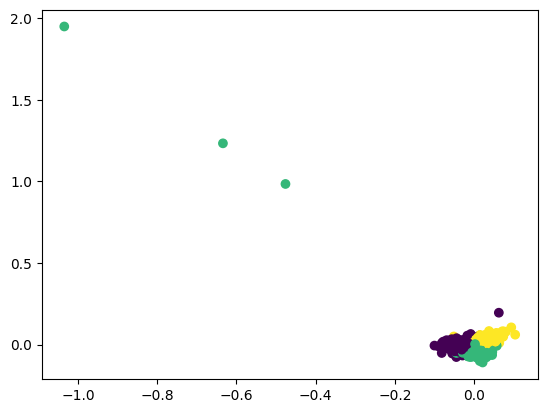

In [151]:
def min(vec):
    min=100000000
    ind=0
    for i in vec:
        if i<min:
            min=i
            minInd=ind
        ind+=1
    return minInd

#project Xtest 
Ztest=Q.T@Xtest
testSize=Ztest.shape[1]
#predict results
Ypredict=[]
print(Ztest[:,0].shape, C1z.shape)
for i in range(testSize):
    D1=np.linalg.norm(Ztest[:,i]-C1z)**2
    D2=np.linalg.norm(Ztest[:,i]-C2z)**2
    D3=np.linalg.norm(Ztest[:,i]-C3z)**2

    minInd=min([D1,D2,D3])  
    if(minInd==0):
        Ypredict.append(0)
    elif(minInd==1):
        Ypredict.append(6)
    else:
        Ypredict.append(9)
print(len(Ypredict))
#calculate accuracy
sum=0
i=0
for y in Ypredict:
    if(y==Ytest[i]):
        sum+=1
    i+=1
print(sum)
accuracy=sum/testSize
print(f"prediction accuracy = {accuracy}")

plt.scatter(Ztest[0,:], Ztest[1,:], c=Ytest)
    